Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [2]:
!pip install wandb

f26c1f8c1968c614fe4b7290f20d5221aa5cb15d
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.4 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=5408e7c57b54af1143b24ca76fc66c8a9e1163b203eab5efbd4f33c6da0bc1cd
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [3]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import shutil
shutil.copytree('/content/drive/MyDrive/Animals_with_Attributes2/','AWA2')

'AWA2'

In [7]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="ResNet18-withoutAugmentation-withoutPreTrain",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "ResNet",
    "dataset": "AWA2",
    "epochs": 10,
    }
)

wandb: Currently logged in as: yuyangxiong23. Use `wandb login --relogin` to force relogin


In [8]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(0)

In [9]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
# DATA_FOLDER_PATH = "/Users/xiongyuyang/Downloads/Animals_with_Attributes2/"
# JPEGIMAGES_FOLDER_PATH = "/Users/xiongyuyang/Downloads/Animals_with_Attributes2/JPEGImages/"
DATA_FOLDER_PATH = '/content/AWA2/'
JPEGIMAGES_FOLDER_PATH = '/content/AWA2/JPEGImages/'

(764, 918, 3)
<class 'numpy.ndarray'>


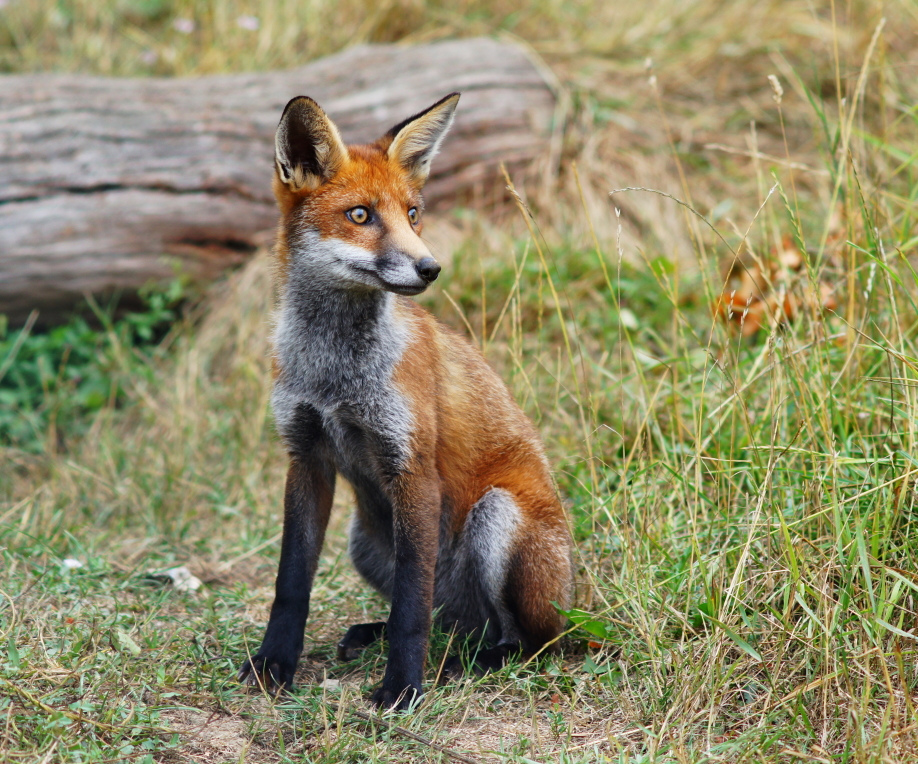

-1

In [ ]:
# quick test
from google.colab.patches import cv2_imshow
test = JPEGIMAGES_FOLDER_PATH+"fox/fox_10001.jpg"
img = cv2.imread(test) 
print(img.shape) #ndarray
print(type(img))
cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
labels_dirs = os.listdir(JPEGIMAGES_FOLDER_PATH)
labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
print(labels_dirs)
len(labels_dirs) # 50 labels / subdirectories

['mouse', 'spider+monkey', 'skunk', 'dalmatian', 'deer', 'hamster', 'siamese+cat', 'antelope', 'blue+whale', 'humpback+whale', 'chihuahua', 'giant+panda', 'mole', 'rabbit', 'sheep', 'chimpanzee', 'squirrel', 'beaver', 'horse', 'cow', 'grizzly+bear', 'gorilla', 'rat', 'rhinoceros', 'tiger', 'wolf', 'moose', 'walrus', 'bobcat', 'seal', 'persian+cat', 'zebra', 'otter', 'elephant', 'leopard', 'ox', 'raccoon', 'dolphin', 'weasel', 'polar+bear', 'german+shepherd', 'collie', 'bat', 'giraffe', 'pig', 'buffalo', 'fox', 'hippopotamus', 'killer+whale', 'lion']


50

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [10]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH) -> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()
print(num_images_per_label)
print(proportions_images_per_label)

{'horse': 1645, 'zebra': 1170, 'spider+monkey': 291, 'blue+whale': 174, 'chihuahua': 567, 'squirrel': 1200, 'siamese+cat': 500, 'chimpanzee': 728, 'sheep': 1420, 'hamster': 779, 'tiger': 877, 'antelope': 1046, 'raccoon': 512, 'buffalo': 895, 'bobcat': 630, 'walrus': 215, 'leopard': 720, 'humpback+whale': 709, 'weasel': 272, 'ox': 728, 'skunk': 188, 'otter': 758, 'giraffe': 1202, 'mole': 100, 'moose': 704, 'collie': 1028, 'pig': 713, 'rabbit': 1088, 'mouse': 185, 'polar+bear': 868, 'gorilla': 872, 'deer': 1344, 'dalmatian': 549, 'fox': 664, 'rat': 310, 'giant+panda': 874, 'grizzly+bear': 852, 'wolf': 589, 'elephant': 1038, 'dolphin': 946, 'rhinoceros': 696, 'cow': 1338, 'hippopotamus': 684, 'seal': 988, 'beaver': 193, 'german+shepherd': 1033, 'killer+whale': 291, 'bat': 383, 'lion': 1019, 'persian+cat': 747}
{'horse': 0.0441, 'zebra': 0.0313, 'spider+monkey': 0.0078, 'blue+whale': 0.0047, 'chihuahua': 0.0152, 'squirrel': 0.0322, 'siamese+cat': 0.0134, 'chimpanzee': 0.0195, 'sheep': 0.03

In [11]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
    labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Sucessfully created annotations.csv file.


In [12]:
# labels_in_number = pd.read_csv(DATA_FOLDER_PATH+"classes.txt", delim_whitespace=True,header=None)
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        # print(line.split())
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [13]:
class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
dataset = AWA2Dataset()
image,label = dataset[4125]

## TODO : Change transforms. Currently this is not useful.
dataset.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the reaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
                    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    transforms.Normalize(mean=[0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538])
                ])

# Testing. All good
# random_index = np.random.randint(0, len(dataset))
# image, label = dataset[1]
# print(label)
# print(image)
train_size =  int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,test_size])

In [15]:
# Experiment with DataLoader. Everything works good
dataloader = DataLoader(dataset = dataset, batch_size=64, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

images, labels = data 
#print(dataloader)#
print(labels, images.shape)
#print(labels)

tensor([47,  1, 29, 35, 30,  6,  2, 13, 12, 38, 32,  6, 48, 49, 23,  6, 35, 30,
        36, 24, 45, 45, 30, 48, 38, 19, 39, 47, 24, 31,  0, 35, 42, 28,  6, 35,
        49, 26, 33, 20, 29, 47, 48,  7, 29, 19, 27, 38, 12, 36, 22, 28,  0, 48,
        13, 44, 39,  0, 37, 36, 42,  7, 13, 22]) torch.Size([64, 3, 224, 224])


In [ ]:
# Training loop example
num_epochs = 10
batch_size = 64
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(total_samples, n_iterations)

dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs) : 
    # loop over trainloader 
    for i, (inputs, labels) in enumerate(dataloader) : 
        
        # Do forward and backward pass, update the weights 
        if(i+1) % 5 == 0 :
            print(f'epoch {epoch+1} / {num_epochs}, step, {i+1}/{n_iterations}, inputs {inputs.shape}')

        if i==20 : 
            print('Completed')
            break


37321 584
epoch 1 / 10, step, 5/584, inputs torch.Size([64, 3, 224, 224])
epoch 1 / 10, step, 10/584, inputs torch.Size([64, 3, 224, 224])
epoch 1 / 10, step, 15/584, inputs torch.Size([64, 3, 224, 224])


KeyboardInterrupt: ignored

In [16]:
from torchvision import models
model = models.resnet18(pretrained=False)
print(model)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is not available, using CPU


In [18]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch.nn as nn
from tqdm.notebook import tqdm

train_loader = DataLoader(train_dataset, batch_size=64, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle= True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 100== 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

# for epoch in range(10):
#     epoch_loss = 0
#     epoch_accuracy = 0

#     for data, label in tqdm(train_loader):
#         data = data.to(device)
#         label = label.to(device)

#         output = model(data)
#         loss = criterion(output, label)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         acc = (output.argmax(dim=1) == label).float().mean()
#         epoch_accuracy += acc / len(train_loader)
#         epoch_loss += loss / len(train_loader)

#     with torch.no_grad():
#         epoch_val_accuracy = 0
#         epoch_val_loss = 0
#         for data, label in valid_loader:
#             data = data.to(device)
#             label = label.to(device)

#             val_output = model(data)
#             val_loss = criterion(val_output, label)

#             acc = (val_output.argmax(dim=1) == label).float().mean()
#             epoch_val_accuracy += acc / len(valid_loader)
#             epoch_val_loss += val_loss / len(valid_loader)

#     print(
#         f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
#     )

#     # log metrics to wandb
#     wandb.log({"loss" : epoch_loss , "acc": epoch_accuracy, "val_loss" : epoch_val_loss, "val_acc": epoch_val_accuracy})



In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=50)

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Fully connected layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle= True)

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 2
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+1) % 500== 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")


KeyboardInterrupt: 

In [ ]:

model.eval()  # switch to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))

Accuracy of the model on the test images: 43.75%
Accuracy of the model on the test images: 43.75%
Accuracy of the model on the test images: 42.19%
Accuracy of the model on the test images: 41.41%
Accuracy of the model on the test images: 38.75%
Accuracy of the model on the test images: 39.06%
Accuracy of the model on the test images: 41.29%
Accuracy of the model on the test images: 42.19%
Accuracy of the model on the test images: 43.06%
Accuracy of the model on the test images: 43.12%
Accuracy of the model on the test images: 42.19%
Accuracy of the model on the test images: 42.32%
Accuracy of the model on the test images: 42.31%
Accuracy of the model on the test images: 42.52%
Accuracy of the model on the test images: 42.71%
Accuracy of the model on the test images: 42.19%
Accuracy of the model on the test images: 41.82%
Accuracy of the model on the test images: 42.01%
Accuracy of the model on the test images: 42.60%
Accuracy of the model on the test images: 42.81%
Accuracy of the mode

KeyboardInterrupt: ignored